In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.
/Users/vishalnigam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vishalnigam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vishalnigam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vishalnigam/anaconda3/lib/pytho

Identify product

In [2]:
product = "RELIANCE.NS"
startDate = "2015-01-01"
toDate = datetime.today().strftime('%Y-%m-%d')

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo(product, start=startDate, end=toDate)

[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd
from stockstats import StockDataFrame as Sdf

In [5]:
stock_prices = Sdf.retype(data)

In [6]:
stock_prices['Date'] = stock_prices.index

In [7]:
stock_prices

,open,high,low,close,adj close,volume,Date
Date,,,,,,,
2015-01-01,443.149994,446.000000,441.825012,443.950012,415.367096,1354878,2015-01-01
2015-01-02,444.049988,448.024994,442.149994,442.774994,414.267700,3351654,2015-01-02
2015-01-05,442.500000,445.450012,437.049988,437.924988,409.729980,4619182,2015-01-05
2015-01-06,435.000000,436.500000,416.000000,418.049988,391.134613,8516086,2015-01-06
2015-01-07,418.549988,429.399994,418.500000,427.149994,399.648712,9472630,2015-01-07
...,...,...,...,...,...,...,...
2020-12-28,2006.699951,2018.000000,1995.300049,2003.300049,2003.300049,7947719,2020-12-28
2020-12-29,2009.000000,2012.300049,1982.550049,1990.050049,1990.050049,8589407,2020-12-29
2020-12-30,1995.250000,2007.199951,1975.550049,1995.500000,1995.500000,10173132,2020-12-30


In [8]:
data = stock_prices
new_data = pd.DataFrame(index=range(0,len(stock_prices)),columns=['Date', 'close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values
train = dataset[0:987,:]
valid = dataset[987:,:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(120,len(train)):
    x_train.append(scaled_data[i-120:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)
inputs = new_data[len(new_data) - len(valid) - 120:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(120,inputs.shape[0]):
    X_test.append(inputs[i-120:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

/Users/vishalnigam/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Epoch 1/5
154s - loss: 8.2201e-04
Epoch 2/5
160s - loss: 2.8947e-04
Epoch 3/5
155s - loss: 2.6587e-04
Epoch 4/5
153s - loss: 1.9347e-04
Epoch 5/5
162s - loss: 1.5043e-04


In [12]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

close          80.700024
Predictions     0.000000
dtype: float64

/Users/vishalnigam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


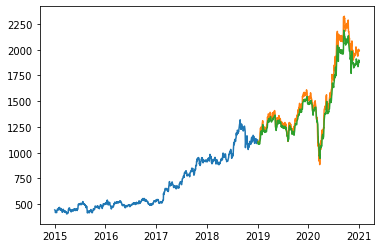

In [10]:
#for plotting
import matplotlib.pyplot as plt
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

Predict future stock prices

In [15]:
inputs = new_data[len(new_data) - 120:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(120,inputs.shape[0]):
    X_test.append(inputs[i-120:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# closing_price = model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)

IndexError: tuple index out of range